In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# ✅ Safe LabelEncoder để tránh lỗi KeyError
class SafeLabelEncoder(LabelEncoder):
    def transform(self, values):
        return [np.where(self.classes_ == val)[0][0] if val in self.classes_ else -1 for val in values]

In [3]:
# 1. Đọc dữ liệu
train_df = pd.read_csv('../Dataset/712/train.csv')
valid_df = pd.read_csv('../Dataset/712/validation.csv')
test_df = pd.read_csv('../Dataset/712/test.csv')

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [4]:
# 2. Hàm tiền xử lý
def preprocess(df, encoders=None, scaler=None, is_train=True):
    df = df.copy()

    # Cột phân loại & số
    categorical_cols = ['film_code', 'cinema_code', 'month', 'quarter', 'day', 'year']
    numerical_cols = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc', 'ticket_use', 'capacity']
    target_col = 'total_sales'

    # Encode cột phân loại
    if is_train:
        encoders = {col: SafeLabelEncoder().fit(df[col].astype(str)) for col in categorical_cols}
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col].astype(str))

    # Scale số
    if is_train:
        scaler = StandardScaler().fit(df[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])

    # Tập dữ liệu
    X = df[categorical_cols + numerical_cols]
    y = df[target_col] if target_col in df.columns else None

    return X, y, encoders, scaler

In [5]:
# 3. Tiền xử lý
X_train, y_train, encoders, scaler = preprocess(train_df, is_train=True)
X_valid, y_valid, _, _ = preprocess(valid_df, encoders, scaler, is_train=False)
X_test, y_test, _, _ = preprocess(test_df, encoders, scaler, is_train=False)

In [6]:
# Chuyển đổi dữ liệu thành DMatrix cho XGBoost
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
valid_dmatrix = xgb.DMatrix(X_valid, label=y_valid)
test_dmatrix = xgb.DMatrix(X_test)

# Cấu hình các tham số cho mô hình XGBoost
params = {
    'objective': 'reg:squarederror',  # Để làm bài toán hồi quy
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'silent': 1
}

# Huấn luyện mô hình XGBoost
num_round = 100  # Số vòng huấn luyện
evals = [(train_dmatrix, 'train'), (valid_dmatrix, 'eval')]
model = xgb.train(params, train_dmatrix, num_round, evals, early_stopping_rounds=10)


[0]	train-rmse:27680533.26928	eval-rmse:31933965.02435
[1]	train-rmse:25347820.20330	eval-rmse:29124180.90125
[2]	train-rmse:23266763.33272	eval-rmse:26632153.98876
[3]	train-rmse:21416061.94732	eval-rmse:24506249.69499
[4]	train-rmse:19760191.06070	eval-rmse:22679646.64330
[5]	train-rmse:18297229.67668	eval-rmse:21067287.40010
[6]	train-rmse:16992182.19360	eval-rmse:19662644.76893
[7]	train-rmse:15822050.21610	eval-rmse:18524959.14579
[8]	train-rmse:14785557.83832	eval-rmse:17535798.18626
[9]	train-rmse:13877239.94768	eval-rmse:16725848.59929
[10]	train-rmse:13062183.90864	eval-rmse:16055271.57954
[11]	train-rmse:12346009.49851	eval-rmse:15500872.33232
[12]	train-rmse:11705466.55783	eval-rmse:15050431.89942


c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [09:45:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[13]	train-rmse:11137315.22219	eval-rmse:14708652.02293
[14]	train-rmse:10652945.76293	eval-rmse:14442948.53110
[15]	train-rmse:10208046.02213	eval-rmse:14246420.25913
[16]	train-rmse:9803058.39250	eval-rmse:14096301.86380
[17]	train-rmse:9427429.50315	eval-rmse:14037150.00731
[18]	train-rmse:9113101.81843	eval-rmse:13951497.00806
[19]	train-rmse:8819452.19818	eval-rmse:13901958.58687
[20]	train-rmse:8588482.37760	eval-rmse:13882803.37044
[21]	train-rmse:8370379.61279	eval-rmse:13858380.43808
[22]	train-rmse:8180916.42201	eval-rmse:13859201.51944
[23]	train-rmse:7976580.10194	eval-rmse:13915824.97667
[24]	train-rmse:7801466.55655	eval-rmse:13932932.43863
[25]	train-rmse:7623893.84862	eval-rmse:14051371.84434
[26]	train-rmse:7480650.71291	eval-rmse:13966751.52780
[27]	train-rmse:7352700.13555	eval-rmse:13972859.51889
[28]	train-rmse:7232020.57841	eval-rmse:13983773.83544
[29]	train-rmse:7112205.59093	eval-rmse:14008217.36200
[30]	train-rmse:7036477.48845	eval-rmse:14045831.00916


In [10]:
# Dự đoán trên tập valid
valid_preds = model.predict(valid_dmatrix)

# Đánh giá mô hình trên tập valid
val_mae = mean_absolute_error(y_valid, valid_preds)
val_mse = mean_squared_error(y_valid, valid_preds)
val_rmse = np.sqrt(val_mse)
val_r2 = r2_score(y_valid, valid_preds)
print(f"Val MAE: {val_mae:.2f}, Val MSE: {val_mse:.2f}, Val RMSE: {val_rmse:.2f}, Val R²: {val_r2:.2f}")

# Dự đoán trên tập test
test_preds = model.predict(test_dmatrix)
test_mae = mean_absolute_error(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_preds)
print(f"Test MAE: {test_mae:.2f}, Test MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

Val MAE: 5805798.61, Val MSE: 196494442768234.75, Val RMSE: 14017647.55, Val R²: 0.84
Test MAE: 3374006.12, Test MSE: 67768896223829.31, Test RMSE: 8232186.60, Test R²: 0.93


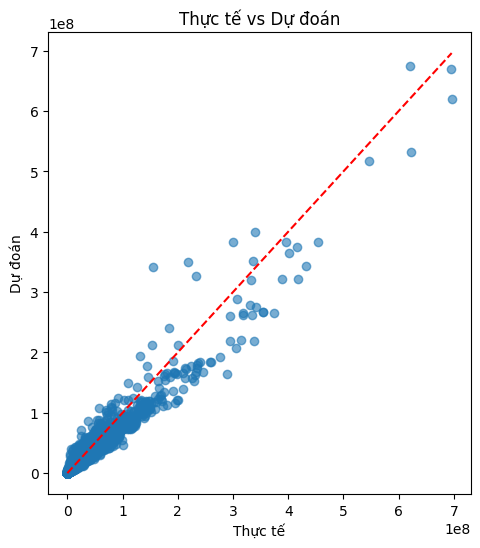

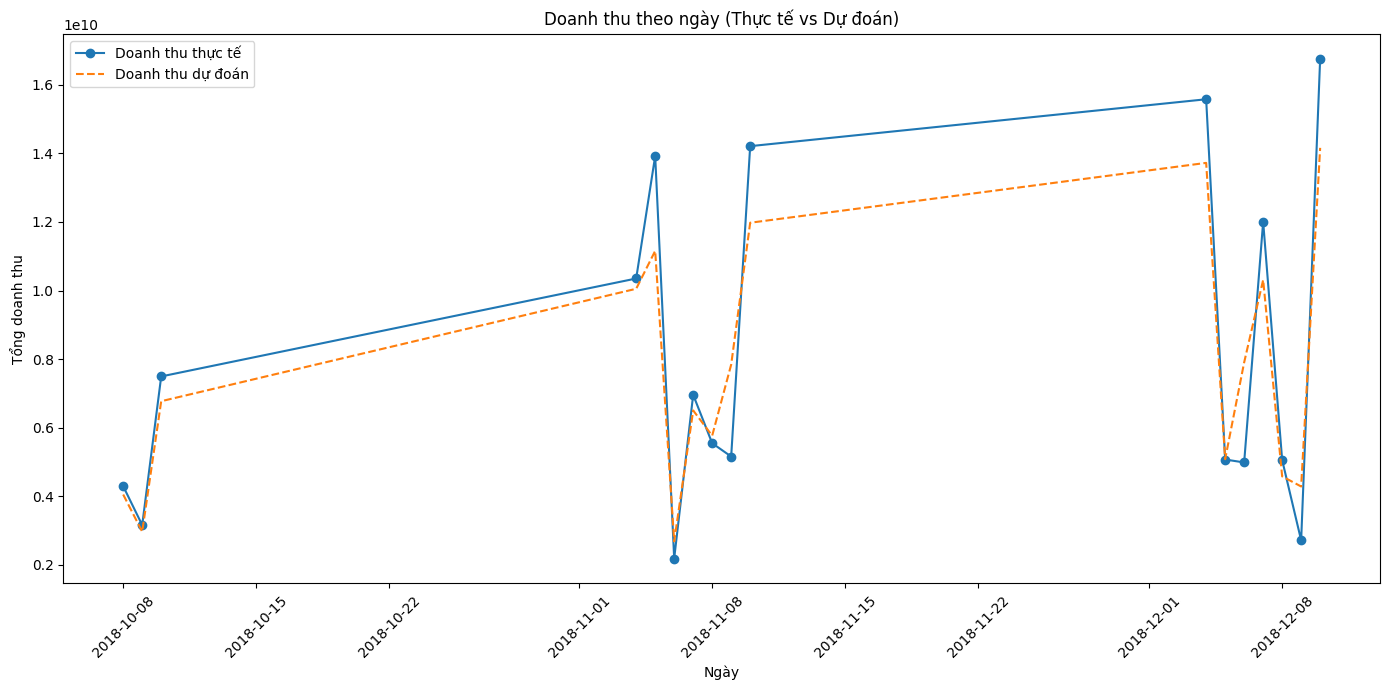

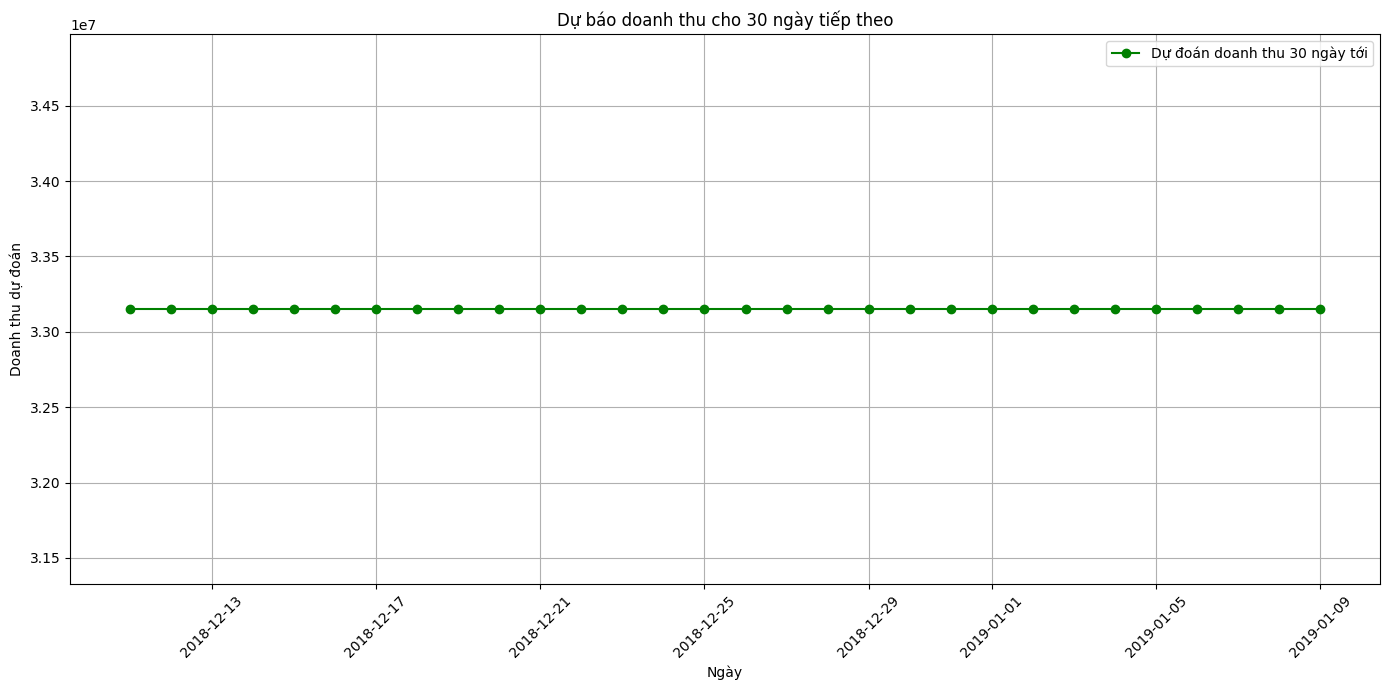

In [12]:
# 9. Vẽ scatter: giá trị thực vs dự đoán
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, test_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Thực tế')
plt.ylabel('Dự đoán')
plt.title('Thực tế vs Dự đoán')

# 10. Vẽ doanh thu theo ngày
if 'date' in test_df.columns:
    test_df['date'] = pd.to_datetime(test_df['date'])
    test_df['PredictedSales'] = test_preds
    test_df['ActualSales'] = y_test

    daily = test_df.groupby(test_df['date'].dt.date).agg({'ActualSales': 'sum', 'PredictedSales': 'sum'}).reset_index()

    plt.figure(figsize=(14, 7))
    plt.plot(daily['date'], daily['ActualSales'], label='Doanh thu thực tế', marker='o')
    plt.plot(daily['date'], daily['PredictedSales'], label='Doanh thu dự đoán', linestyle='--')
    plt.xlabel('Ngày')
    plt.ylabel('Tổng doanh thu')
    plt.title('Doanh thu theo ngày (Thực tế vs Dự đoán)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 11. Dự đoán doanh thu từ ngày cuối cùng trong test_df cho 30 ngày tiếp theo
last_date = pd.to_datetime(test_df['date']).max()

# Tạo ra một dataframe với ngày mới từ ngày cuối cùng trong test_df
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Lấy một hàng mẫu từ cuối test_df để làm cơ sở
last_sample = test_df.tail(1).copy()
last_sample['date'] = future_dates[0]

# Lặp qua để dự đoán cho 30 ngày tiếp theo
future_preds = []
for date in future_dates:
    # Cập nhật lại ngày cho mỗi lần dự đoán
    last_sample['date'] = date
    X_future, _, _, _ = preprocess(last_sample, encoders, scaler, is_train=False)
    future_dmatrix = xgb.DMatrix(X_future)
    future_pred = model.predict(future_dmatrix)
    future_preds.append(future_pred[0])

# Tạo dataframe với dự đoán
future_df = pd.DataFrame({'date': future_dates, 'PredictedSales': future_preds})

# Vẽ kết quả dự đoán doanh thu 30 ngày tiếp theo
plt.figure(figsize=(14, 7))
plt.plot(future_df['date'], future_df['PredictedSales'], label='Dự đoán doanh thu 30 ngày tới', color='green', marker='o')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu dự đoán')
plt.title('Dự báo doanh thu cho 30 ngày tiếp theo')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()